In [48]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI, RFPlusLime
from subgroup_detection import *
import warnings
import shap
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [49]:
# get pre-cleaned compas dataset from imodels
X, _, feature_names = get_clean_dataset(43463, data_source='openml')
X = pd.DataFrame(X, columns=feature_names)

# Introduction
## About the Dataset
Throughout this report, we will be looking at the `insurance` dataset, which can be found on OpenML [here](https://www.openml.org/search?type=data&status=active&id=43463). Each row in this dataset represents an individual on some (unknown) health insurance plan. The task is to predict someone's medical expenses using demographic information such as age, sex, smoker status, and more. We take a peek at the data below:

In [50]:
X.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,0.0,27.900,0.0,1.0,3.0,16884.92400
1,18.0,1.0,33.770,1.0,0.0,2.0,1725.55230
2,28.0,1.0,33.000,3.0,0.0,2.0,4449.46200
3,33.0,1.0,22.705,0.0,0.0,1.0,21984.47061
4,32.0,1.0,28.880,0.0,0.0,1.0,3866.85520


In [51]:
y = X.pop('charges')
print("Dimensions of the Insurance Dataset (Covariates):", X.shape)
print("Dimensions of the Response:", y.shape)

Dimensions of the Insurance Dataset (Covariates): (1338, 6)
Dimensions of the Response: (1338,)


Before we begin analyzing our data, we first perform some simple exploratory data analysis.

In [52]:
print("---------------------------------------------")
# get correlation between age and charges
print("The Pearson Correlation Coefficient Between Age and Charges is:",
      round(X['age'].corr(y), 2))
print("---------------------------------------------")
# get the average charge by sex
print("The Average Charge for Men is:", round(y[X['sex']==1].mean(), 2))
print("The Average Charge for Women is:", round(y[X['sex']==0].mean(), 2))
print("---------------------------------------------")
# get correlation between bmi and charges
print("The Pearson Correlation Coefficient Between BMI and Charges is:",
      round(X['bmi'].corr(y), 2))
print("---------------------------------------------")
# get the correlation between children and charges
print("The Pearson Correlation Coefficient Between # of \
Children and Charges is:", round(X['children'].corr(y), 2))
print("---------------------------------------------")
# get the average charge by smoker status
print("The Average Charge for Smokers is:", round(y[X['smoker']==1].mean(), 2))
print("The Average Charge for Non-Smokers is:",
      round(y[X['smoker']==0].mean(), 2))
print("---------------------------------------------")
# get the average charge by region
print("The Average Charge for Region #1 is:",
      round(y[X['region']==0].mean(), 2))
print("The Average Charge for Region #2 is:",
      round(y[X['region']==1].mean(), 2))
print("The Average Charge for Region #3 is:",
      round(y[X['region']==2].mean(), 2))
print("The Average Charge for Region #4 is:",
      round(y[X['region']==3].mean(), 2))
print("---------------------------------------------")

---------------------------------------------
The Pearson Correlation Coefficient Between Age and Charges is: 0.3
---------------------------------------------
The Average Charge for Men is: 13956.75
The Average Charge for Women is: 12569.58
---------------------------------------------
The Pearson Correlation Coefficient Between BMI and Charges is: 0.2
---------------------------------------------
The Pearson Correlation Coefficient Between # of Children and Charges is: 0.07
---------------------------------------------
The Average Charge for Smokers is: 32050.23
The Average Charge for Non-Smokers is: 8434.27
---------------------------------------------
The Average Charge for Region #1 is: 13406.38
The Average Charge for Region #2 is: 12417.58
The Average Charge for Region #3 is: 14735.41
The Average Charge for Region #4 is: 12346.94
---------------------------------------------


It is apparent that while multiple variables might impact the medical expenses of an individual, the most eye-popping difference is the average expense difference between smokers and non-smokers.

Now, we split the data into training and testing datasets using a 70/30 split. We check for covariate balance in our train/test split below. We do not include `region` in this covariate balance check for the sake of brevity.

In [53]:
# split data into training and testing sets
# we won't actually use the test set here though, since 'discovery' would be
# a post-hoc analysis in real life
# proportion of training data is small so rf+ can fit without taking hours
y = np.asarray(np.log(y+1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=1)

In [54]:
print("---------------------------------------------")
print("Number of Observations in Training Data:", X_train.shape[0])
print("Number of Observations in Testing Data:", X_test.shape[0])
print("---------------------------------------------")
print("Average of Age in Training Data:", X_train['age'].mean())
print("Average of Age in Testing Data:", X_test['age'].mean())
print("---------------------------------------------")
print("Proportion of Men in Training Data:", X_train['sex'].mean())
print("Proportion of Men in Testing Data:", X_test['sex'].mean())
print("---------------------------------------------")
print("Proportion of Women in Training Data:", 1-X_train['sex'].mean())
print("Proportion of Women in Testing Data:", 1-X_test['sex'].mean())
print("---------------------------------------------")
print("Average of # of Children in Training Data:", X_train['children'].mean())
print("Average of # of Children in Testing Data:", X_test['children'].mean())
print("---------------------------------------------")
print("Proportion of Smokers in Training Data:", X_train['smoker'].mean())
print("Proportion of Smokers in Testing Data:", X_test['smoker'].mean())
print("---------------------------------------------")
print("Average (Log) Charge in Training Data:", y_train.mean())
print("Average (Log) Charge in Testing Data:", y_test.mean())
print("---------------------------------------------")

---------------------------------------------
Number of Observations in Training Data: 936
Number of Observations in Testing Data: 402
---------------------------------------------
Average of Age in Training Data: 38.822649572649574
Average of Age in Testing Data: 40.101990049751244
---------------------------------------------
Proportion of Men in Training Data: 0.5117521367521367
Proportion of Men in Testing Data: 0.4900497512437811
---------------------------------------------
Proportion of Women in Training Data: 0.4882478632478633
Proportion of Women in Testing Data: 0.5099502487562189
---------------------------------------------
Average of # of Children in Training Data: 1.1047008547008548
Average of # of Children in Testing Data: 1.072139303482587
---------------------------------------------
Proportion of Smokers in Training Data: 0.20619658119658119
Proportion of Smokers in Testing Data: 0.20149253731343283
---------------------------------------------
Average (Log) Charge in

The train and test datasets seem reasonable, so we continue with our analysis.
# Baseline 'Global' Model
We begin by fitting a RF+ to the training data. The R^2 on the test data is reported below. The total squared error (TSE) is also reported, as we will use this to compare the 'global' model fit on all of the data to the 'local' models fit on each cluster.

In [55]:
# fit RF+ model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
rf_plus = RandomForestPlusRegressor(rf)
rf_plus.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished


In [56]:
# compute r^2 on the test set
y_pred = rf_plus.predict(X_test)
r2 = r2_score(y_test, y_pred)
tse = np.sum((y_test - y_pred)**2)
print(f'RF+ Test Set R^2: {r2}')
print(f'RF+ Test Set TSE: {tse}')

RF+ Test Set R^2: 0.8535953274461104
RF+ Test Set TSE: 49.49116893683127


In the following sections, we will compute subgroups using the RF/RF+ fit on the training data. We will then assign each test point to these subgroups using various methods. This will give us clusters that are composed of both training and testing points, allowing us to fit separate RF/RF+'s to the training data in each of these subgroups and predict the testing data. This will allow us to compare the TSE of the global model to the summed TSEs of the 'local' models fit on the clusters. Intuitively, the drop in TSE acheived in the local models will be directly related to how 'accurate' the subgroups determined by local feature importance are.

When clustering our data, we will compute the ranking-based overlap (RBO) between each pair of points, and then use this as the distance matrix for hierarchical clustering with Ward linkage. The number of clusters will be chosen based on the appearance of the heatmap. It may be worth trying this with a range of cluster amounts and checking how it changes model performance - we could perhaps make a train/validate/test split, where we choose the number of clusters that results in the lowest total squared error in the 'local' models (or perhaps make an elbow plot, since the performance should only improve as # of clusters increases).

# Local MDI+

To detect subgroups using Local MDI+, we convert the Local MDI+ scores to feature rankings, and then compute RBO, as described above. We compute LMDI+ for the training points by using $metric(y_i, \hat{y}^{(k)}_i)$. The resulting clusters can be visualized below.

In [57]:
# get feature importances
mdi_explainer = AloRFPlusMDI(rf_plus, evaluate_on='oob')
mdi, partial_preds = mdi_explainer.explain(np.asarray(X_train), y_train)
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [58]:
# get rbo distance matrix
rbo_train = compute_rbo_matrix(mdi_rankings, form = 'distance')

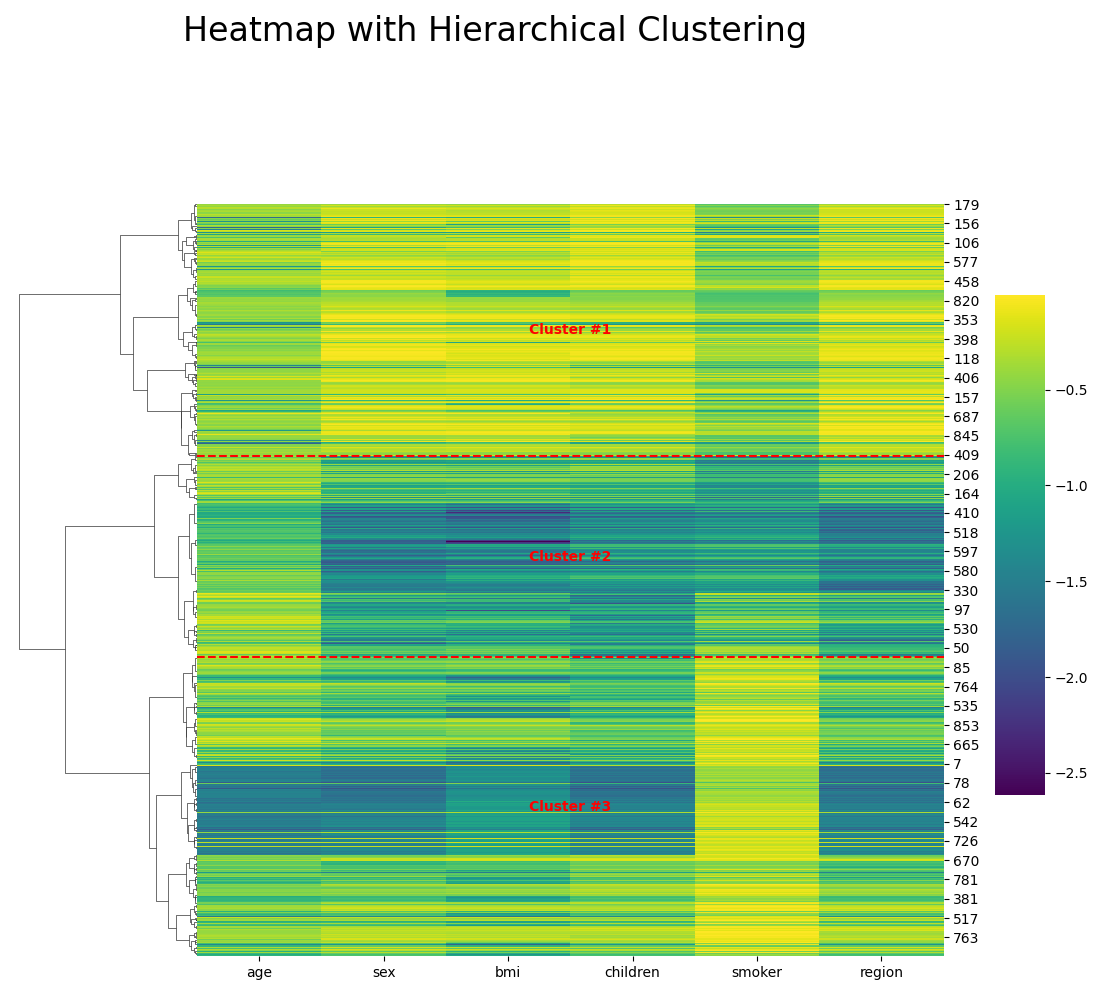

In [59]:
mdi_copy = pd.DataFrame(mdi, columns=feature_names[:-1]).copy()
num_clusters = 3
clusters = assign_training_clusters(mdi_copy, rbo_train, num_clusters)

It is easy to see that these subgroups differ in feature importance, as shown above. However, just because they differ in feature importance does not necessarily imply that they differ in the values of those features themselves. We now check some useful summary statistics for each cluster to better understand how we have grouped the data.

In [60]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Data in Cluster #{i+1}:", X_train[clusters==i+1].shape[0]/X_train.shape[0])
print("---------------------------------------------")
# get average age in each cluster
for i in range(num_clusters):
    print(f"Average Age in Cluster #{i+1}:", X_train[clusters==i+1]['age'].mean())
print("---------------------------------------------")
# get percentage women in each cluster
for i in range(num_clusters):
    print(f"Proportion of Women in Cluster #{i+1}:", 1-X_train[clusters==i+1]['sex'].mean())
print("---------------------------------------------")
# get percentage men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Cluster #{i+1}:", X_train[clusters==i+1]['sex'].mean())
print("---------------------------------------------")
# get average bmi in each cluster
for i in range(num_clusters):
    print(f"Average BMI in Cluster #{i+1}:", X_train[clusters==i+1]['bmi'].mean())
print("---------------------------------------------")
# get average number of children in each cluster
for i in range(num_clusters):
    print(f"Average # of Children in Cluster #{i+1}:", X_train[clusters==i+1]['children'].mean())
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Proportion of Smokers in Cluster #{i+1}:", X_train[clusters==i+1]['smoker'].mean())
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Average Medical Expenses in Cluster #{i+1}:", y_train[clusters==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Data in Cluster #1: 0.33547008547008544
Proportion of Data in Cluster #2: 0.2670940170940171
Proportion of Data in Cluster #3: 0.3974358974358974
---------------------------------------------
Average Age in Cluster #1: 47.4140127388535
Average Age in Cluster #2: 30.228
Average Age in Cluster #3: 37.346774193548384
---------------------------------------------
Proportion of Women in Cluster #1: 0.5222929936305732
Proportion of Women in Cluster #2: 0.516
Proportion of Women in Cluster #3: 0.4408602150537635
---------------------------------------------
Proportion of Men in Cluster #1: 0.47770700636942676
Proportion of Men in Cluster #2: 0.484
Proportion of Men in Cluster #3: 0.5591397849462365
---------------------------------------------
Average BMI in Cluster #1: 30.49052547770701
Average BMI in Cluster #2: 30.115599999999997
Average BMI in Cluster #3: 31.224731182795693
---------------------------------------------
Average # 

## Evaluating Cluster Performance - Centroid Method w/ Exact Mean
Now that we have a good idea of what our clustering has done, we can check if this helps improve our predictions. We compute LMDI+ of test points using $metric(\hat{y}_i, \hat{y}^{(k)}_i)$. We will take the test points and determine their cluster membership based on their RBO similarity to the mean point in each cluster (in RBO embedding). We will then fit a RF+ on the training data and using it to predict the test data for that cluster. We can then compute the R^2 and total squared error for each cluster's model. By summing the TSE across cluster models and comparing this to the original TSE reported above, we can get a good idea of how well these clusters improve model accuracy.

In [61]:
# get mdi rankings assignments for test points
mdi_test, partial_preds_test = mdi_explainer.explain(np.asarray(X_test))
mdi_test_rankings = mdi_explainer.get_rankings(mdi_test)

In [62]:
test_clust = assign_testing_clusters(method = "centroid", median_approx = False,
                                     rbo_distance_matrix = rbo_train,
                                     lfi_train_ranking = mdi_rankings,
                                     lfi_test_ranking = mdi_test_rankings,
                                     clusters = clusters)

In [63]:
cluster1_trainX = X_train[clusters == 1]
cluster2_trainX = X_train[clusters == 2]
cluster3_trainX = X_train[clusters == 3]
# cluster4_trainX = X_train[clusters == 4]
# cluster5_trainX = X_train[clusters == 5]
# cluster6_trainX = X_train[clusters == 6]
# cluster7_trainX = X_train[clusters == 7]

cluster1_trainy = y_train[clusters == 1]
cluster2_trainy = y_train[clusters == 2]
cluster3_trainy = y_train[clusters == 3]
# cluster4_trainy = y_train[clusters == 4]
# cluster5_trainy = y_train[clusters == 5]
# cluster6_trainy = y_train[clusters == 6]
# cluster7_trainy = y_train[clusters == 7]

cluster1_testX = X_test[test_clust == 1]
cluster2_testX = X_test[test_clust == 2]
cluster3_testX = X_test[test_clust == 3]
# cluster4_testX = X_test[test_clust == 4]
# cluster5_testX = X_test[test_clust == 5]
# cluster6_testX = X_test[test_clust == 6]
# cluster7_testX = X_test[test_clust == 7]

cluster1_testy = y_test[test_clust == 1]
cluster2_testy = y_test[test_clust == 2]
cluster3_testy = y_test[test_clust == 3]
# cluster4_testy = y_test[test_clust == 4]
# cluster5_testy = y_test[test_clust == 5]
# cluster6_testy = y_test[test_clust == 6]
# cluster7_testy = y_test[test_clust == 7]

In [64]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Train Data in Cluster #{i+1}: {X_train[clusters==i+1].shape[0]/X_train.shape[0]};",
          f"Proportion of Test Data in Cluster #{i+1}: {X_test[test_clust==i+1].shape[0]/X_test.shape[0]}")
print("---------------------------------------------")
# get average age in each cluster
for i in range(num_clusters):
    print(f"Average Age in Train Cluster #{i+1}:, {X_train[clusters==i+1]['age'].mean()};",
          f"Average Age in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['age'].mean()}")
print("---------------------------------------------")
# get percentage women in each cluster
for i in range(num_clusters):
    print(f"Proportion of Women in Train Cluster #{i+1}:, {1-X_train[clusters==i+1]['sex'].mean()};",
          f"Proportion of Women in Test Cluster #{i+1}:, {1-X_test[test_clust==i+1]['sex'].mean()}")    
print("---------------------------------------------")
# get percentage men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Train Cluster #{i+1}:, {X_train[clusters==i+1]['sex'].mean()};",
          f"Proportion of Men in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['sex'].mean()}")
print("---------------------------------------------")
# get average bmi in each cluster
for i in range(num_clusters):
    print(f"Average BMI in Train Cluster #{i+1}:, {X_train[clusters==i+1]['bmi'].mean()};",
          f"Average BMI in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['bmi'].mean()}")
print("---------------------------------------------")
# get average number of children in each cluster
for i in range(num_clusters):
    print(f"Average # of Children in Train Cluster #{i+1}:, {X_train[clusters==i+1]['children'].mean()};",
          f"Average # of Children in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['children'].mean()}")
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Proportion of Smokers in Train Cluster #{i+1}:, {X_train[clusters==i+1]['smoker'].mean()};",
          f"Proportion of Smokers in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['smoker'].mean()}")
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Average Medical Expenses in Train Cluster #{i+1}:, {y_train[clusters==i+1].mean()};",
          f"Average Medical Expenses in Test Cluster #{i+1}:, {y_test[test_clust==i+1].mean()}")
print("---------------------------------------------")

---------------------------------------------
Proportion of Train Data in Cluster #1: 0.33547008547008544; Proportion of Test Data in Cluster #1: 0.27860696517412936
Proportion of Train Data in Cluster #2: 0.2670940170940171; Proportion of Test Data in Cluster #2: 0.3706467661691542
Proportion of Train Data in Cluster #3: 0.3974358974358974; Proportion of Test Data in Cluster #3: 0.35074626865671643
---------------------------------------------
Average Age in Train Cluster #1:, 47.4140127388535; Average Age in Test Cluster #1:, 49.205357142857146
Average Age in Train Cluster #2:, 30.228; Average Age in Test Cluster #2:, 34.77181208053691
Average Age in Train Cluster #3:, 37.346774193548384; Average Age in Test Cluster #3:, 38.50354609929078
---------------------------------------------
Proportion of Women in Train Cluster #1:, 0.5222929936305732; Proportion of Women in Test Cluster #1:, 0.5178571428571428
Proportion of Women in Train Cluster #2:, 0.516; Proportion of Women in Test Clus

In [65]:
# fit RF+ on each training set, predict test
rf1 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus1 = RandomForestPlusRegressor(rf1)
rf_plus1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestRegressor(n_estimators=100, random_state=1)
rf_plus2 = RandomForestPlusRegressor(rf2)
rf_plus2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus3 = RandomForestPlusRegressor(rf3)
rf_plus3.fit(cluster3_trainX, cluster3_trainy)

# rf4 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf_plus4 = RandomForestPlusRegressor(rf4)
# rf_plus4.fit(cluster4_trainX, cluster4_trainy)

# rf5 = RandomForestRegressor(n_estimators=100, random_state=1)
# rf_plus5 = RandomForestPlusRegressor(rf5)
# rf_plus5.fit(cluster5_trainX, cluster5_trainy)

# rf6 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf_plus6 = RandomForestPlusRegressor(rf6)
# rf_plus6.fit(cluster6_trainX, cluster6_trainy)

# rf7 = RandomForestRegressor(n_estimators=100, random_state=1)
# rf_plus7 = RandomForestPlusRegressor(rf7)
# rf_plus7.fit(cluster7_trainX, cluster7_trainy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.6s finished


In [66]:
# compute r^2 on the test set
print("---------------------------------------------")
y_pred1 = rf_plus1.predict(cluster1_testX)
r2 = r2_score(cluster1_testy, y_pred1)
tse1 = np.sum((cluster1_testy - y_pred1)**2)
y_pred_g1 = rf_plus.predict(cluster1_testX)
r2g = r2_score(cluster1_testy, y_pred_g1)
tse1g = np.sum((cluster1_testy - y_pred_g1)**2)
print(f'Local RF+ Cluster #1 Test Set R^2: {r2}')
print(f'Local RF+ Cluster #1 Test Set TSE: {tse1}')
print(f'Global RF+ Cluster #1 Test Set R^2: {r2g}')
print(f'Global RF+ Cluster #1 Test Set TSE: {tse1g}')
print(f'% Improvement in TSE: {(tse1g - tse1)/tse1*100:.2f}')
print("---------------------------------------------")
y_pred2 = rf_plus2.predict(cluster2_testX)
r2 = r2_score(cluster2_testy, y_pred2)
tse2 = np.sum((cluster2_testy - y_pred2)**2)
y_pred_g2 = rf_plus.predict(cluster2_testX)
r2g = r2_score(cluster2_testy, y_pred_g2)
tse2g = np.sum((cluster2_testy - y_pred_g2)**2)
print(f'Local RF+ Cluster #2 Test Set R^2: {r2}')
print(f'Local RF+ Cluster #2 Test Set TSE: {tse2}')
print(f'Global RF+ Cluster #2 Test Set R^2: {r2g}')
print(f'Global RF+ Cluster #2 Test Set TSE: {tse2g}')
print(f'% Improvement in TSE: {(tse2g - tse2)/tse2*100:.2f}')
print("---------------------------------------------")
y_pred3 = rf_plus3.predict(cluster3_testX)
r2 = r2_score(cluster3_testy, y_pred3)
tse3 = np.sum((cluster3_testy - y_pred3)**2)
y_pred_g3 = rf_plus.predict(cluster3_testX)
r2 = r2_score(cluster3_testy, y_pred_g3)
tse3g = np.sum((cluster3_testy - y_pred_g3)**2)
print(f'Local RF+ Cluster #3 Test Set R^2: {r2}')
print(f'Local RF+ Cluster #3 Test Set TSE: {tse3}')
print(f'Global RF+ Cluster #3 Test Set R^2: {r2g}')
print(f'Global RF+ Cluster #3 Test Set TSE: {tse3g}')
print(f'% Improvement in TSE: {(tse3g - tse3)/tse3*100:.2f}')
print("---------------------------------------------")
# y_pred4 = rf_plus4.predict(cluster4_testX)
# r2 = r2_score(cluster4_testy, y_pred4)
# tse4 = np.sum((cluster4_testy - y_pred4)**2)
# y_pred_g4 = rf_plus.predict(cluster4_testX)
# r2g = r2_score(cluster4_testy, y_pred_g4)
# tse4g = np.sum((cluster4_testy - y_pred_g4)**2)
# print(f'Local RF+ Cluster #4 Test Set R^2: {r2}')
# print(f'Local RF+ Cluster #4 Test Set TSE: {tse4}')
# print(f'Global RF+ Cluster #4 Test Set R^2: {r2g}')
# print(f'Global RF+ Cluster #4 Test Set TSE: {tse4g}')
# print(f'% Improvement in TSE: {(tse4g - tse4)/tse4*100:.2f}')
# print("---------------------------------------------")
# y_pred5 = rf_plus5.predict(cluster5_testX)
# r2 = r2_score(cluster5_testy, y_pred5)
# tse5 = np.sum((cluster5_testy - y_pred5)**2)
# y_pred_g5 = rf_plus.predict(cluster5_testX)
# r2g = r2_score(cluster5_testy, y_pred_g5)
# tse5g = np.sum((cluster5_testy - y_pred_g5)**2)
# print(f'Local RF+ Cluster #5 Test Set R^2: {r2}')
# print(f'Local RF+ Cluster #5 Test Set TSE: {tse5}')
# print(f'Global RF+ Cluster #5 Test Set R^2: {r2g}')
# print(f'Global RF+ Cluster #5 Test Set TSE: {tse5g}')
# print(f'% Improvement in TSE: {(tse5g - tse5)/tse5*100:.2f}')
# print("---------------------------------------------")
# y_pred6 = rf_plus6.predict(cluster6_testX)
# r2 = r2_score(cluster6_testy, y_pred6)
# tse6 = np.sum((cluster6_testy - y_pred6)**2)
# y_pred_g6 = rf_plus.predict(cluster6_testX)
# r2g = r2_score(cluster6_testy, y_pred_g6)
# tse6g = np.sum((cluster6_testy - y_pred_g6)**2)
# print(f'Local RF+ Cluster #6 Test Set R^2: {r2}')
# print(f'Local RF+ Cluster #6 Test Set TSE: {tse6}')
# print(f'Global RF+ Cluster #6 Test Set R^2: {r2g}')
# print(f'Global RF+ Cluster #6 Test Set TSE: {tse6g}')
# print(f'% Improvement in TSE: {(tse6g - tse6)/tse6*100:.2f}')
# print("---------------------------------------------")
# y_pred7 = rf_plus7.predict(cluster7_testX)
# r2 = r2_score(cluster7_testy, y_pred7)
# tse7 = np.sum((cluster7_testy - y_pred7)**2)
# y_pred_g7 = rf_plus.predict(cluster7_testX)
# r2g = r2_score(cluster7_testy, y_pred_g7)
# tse7g = np.sum((cluster7_testy - y_pred_g7)**2)
# print(f'Local RF+ Cluster #7 Test Set R^2: {r2}')
# print(f'Local RF+ Cluster #7 Test Set TSE: {tse7}')
# print(f'Global RF+ Cluster #7 Test Set R^2: {r2g}')
# print(f'Global RF+ Cluster #7 Test Set TSE: {tse7g}')
# print(f'% Improvement in TSE: {(tse7g - tse7)/tse7*100:.2f}')
# print("---------------------------------------------")

---------------------------------------------
Local RF+ Cluster #1 Test Set R^2: -0.11724094675708985
Local RF+ Cluster #1 Test Set TSE: 14.949604098796454
Global RF+ Cluster #1 Test Set R^2: 0.029493163020803292
Global RF+ Cluster #1 Test Set TSE: 12.986180850359272
% Improvement in TSE: -13.13
---------------------------------------------
Local RF+ Cluster #2 Test Set R^2: 0.6772757620329343
Local RF+ Cluster #2 Test Set TSE: 38.95704027567547
Global RF+ Cluster #2 Test Set R^2: 0.781584506318687
Global RF+ Cluster #2 Test Set TSE: 26.365609344293446
% Improvement in TSE: -32.32
---------------------------------------------
Local RF+ Cluster #3 Test Set R^2: 0.9078883801833639
Local RF+ Cluster #3 Test Set TSE: 6.596004099534014
Global RF+ Cluster #3 Test Set R^2: 0.781584506318687
Global RF+ Cluster #3 Test Set TSE: 10.139378742178563
% Improvement in TSE: 53.72
---------------------------------------------


In [67]:
print("---------------------------------------------")
print("Total # of Observations Predicted by Global Model:", X_test.shape[0])
print("Total # of Observations Predicted by Cluster Models:",
      cluster1_testX.shape[0] + cluster2_testX.shape[0] + \
          cluster3_testX.shape[0])
print("---------------------------------------------")
print("Difference in TSE (Global - Sum of Clusters):", round(tse - (tse1 + tse2 + tse3), 2))
print(f"Percent Improvement Over Global Model: {round(100*(tse - (tse1 + tse2 + tse3))/tse, 2)}%")
print("---------------------------------------------")

---------------------------------------------
Total # of Observations Predicted by Global Model: 402
Total # of Observations Predicted by Cluster Models: 402
---------------------------------------------
Difference in TSE (Global - Sum of Clusters): -11.01
Percent Improvement Over Global Model: -22.25%
---------------------------------------------


In [68]:
# order rows of mdi_test by cluster assignment
mdi_test_clust = mdi_test[np.argsort(test_clust)]

In [69]:
# order test clust by cluster assignment
test_clust_org = test_clust[np.argsort(test_clust)]

In [70]:
# get indexes where mdi_test_clust changes clusters
cluster_changes = np.where(np.diff(test_clust_org) != 0)[0]

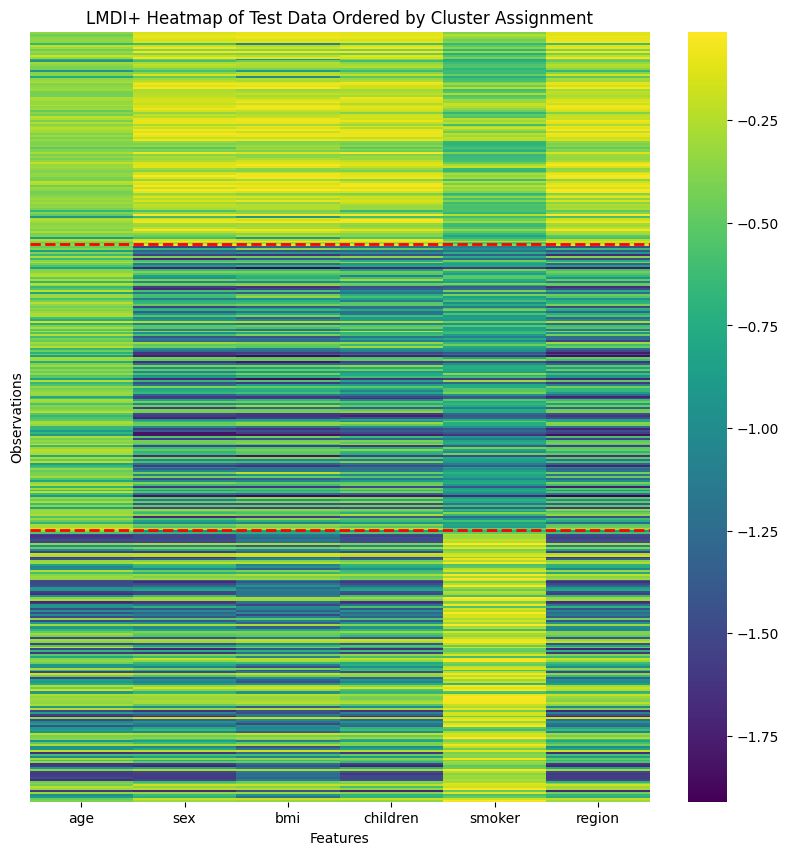

In [71]:
# create new heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(mdi_test_clust, cmap='viridis')
plt.xlabel('Features')
plt.ylabel('Observations')
plt.title('LMDI+ Heatmap of Test Data Ordered by Cluster Assignment')
plt.yticks([])
plt.xticks(np.arange(len(feature_names[:-1])) + 0.5, feature_names[:-1])
# put horizontal lines where cluster membership changes
for i in cluster_changes:
    plt.axhline(i, color='red', linewidth=2, linestyle='--')
plt.show()

In [72]:
# get most important feature on average for each cluster
for i in range(num_clusters):
    print(f'The most important feature for Train Cluster #{i+1} is:', X.columns[np.argmax(np.mean(mdi[clusters==i+1], axis=0))])
    print(f'The most important feature for Test Cluster #{i+1} is:', X.columns[np.argmax(np.mean(mdi_test[test_clust==i+1], axis=0))])

The most important feature for Train Cluster #1 is: region
The most important feature for Test Cluster #1 is: sex
The most important feature for Train Cluster #2 is: age
The most important feature for Test Cluster #2 is: age
The most important feature for Train Cluster #3 is: smoker
The most important feature for Test Cluster #3 is: smoker


In [73]:
for i in range(num_clusters):
    # negative is taken because argsort goes in the wrong order
    print(f'The feature ranking for Train Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(mdi[clusters==i+1], axis=0))]))
    print(f'The feature ranking for Test Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(mdi_test[test_clust==i+1], axis=0))]))

The feature ranking for Train Cluster #1 is: ['region', 'sex', 'children', 'bmi', 'age', 'smoker']
The feature ranking for Test Cluster #1 is: ['sex', 'region', 'children', 'bmi', 'age', 'smoker']
The feature ranking for Train Cluster #2 is: ['age', 'smoker', 'children', 'region', 'bmi', 'sex']
The feature ranking for Test Cluster #2 is: ['age', 'smoker', 'children', 'bmi', 'sex', 'region']
The feature ranking for Train Cluster #3 is: ['smoker', 'age', 'bmi', 'region', 'sex', 'children']
The feature ranking for Test Cluster #3 is: ['smoker', 'bmi', 'children', 'region', 'sex', 'age']


# TreeSHAP

To detect subgroups using TreeSHAP, we obtain the TreeSHAP scores from the fitted random forest that was given to the RF+ constructor. We then convert these importance scores to feature rankings and compute RBO, which is the same process we underwent for Local MDI+. The resulting clusters can be visualized below. It is worth noting that we evaluate the RF here instead of the RF+. This is due to two reasons: TreeSHAP is made for RFs, not RF+s, and the clusters made by TreeSHAP are too small to fit RF+s (due to cross-validation).

In [74]:
# compute r^2 on the test set
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
tse = np.sum((y_test - y_pred)**2)
print(f'RF Test Set R^2: {r2}')
print(f'RF Test Set TSE: {tse}')

RF Test Set R^2: 0.8457991205543834
RF Test Set TSE: 52.126627120059155


In [75]:
explainer = shap.TreeExplainer(rf)

In [76]:
shap_values = np.abs(explainer.shap_values(X_train, check_additivity=False))

In [77]:
shap_rankings = mdi_explainer.get_rankings(shap_values)

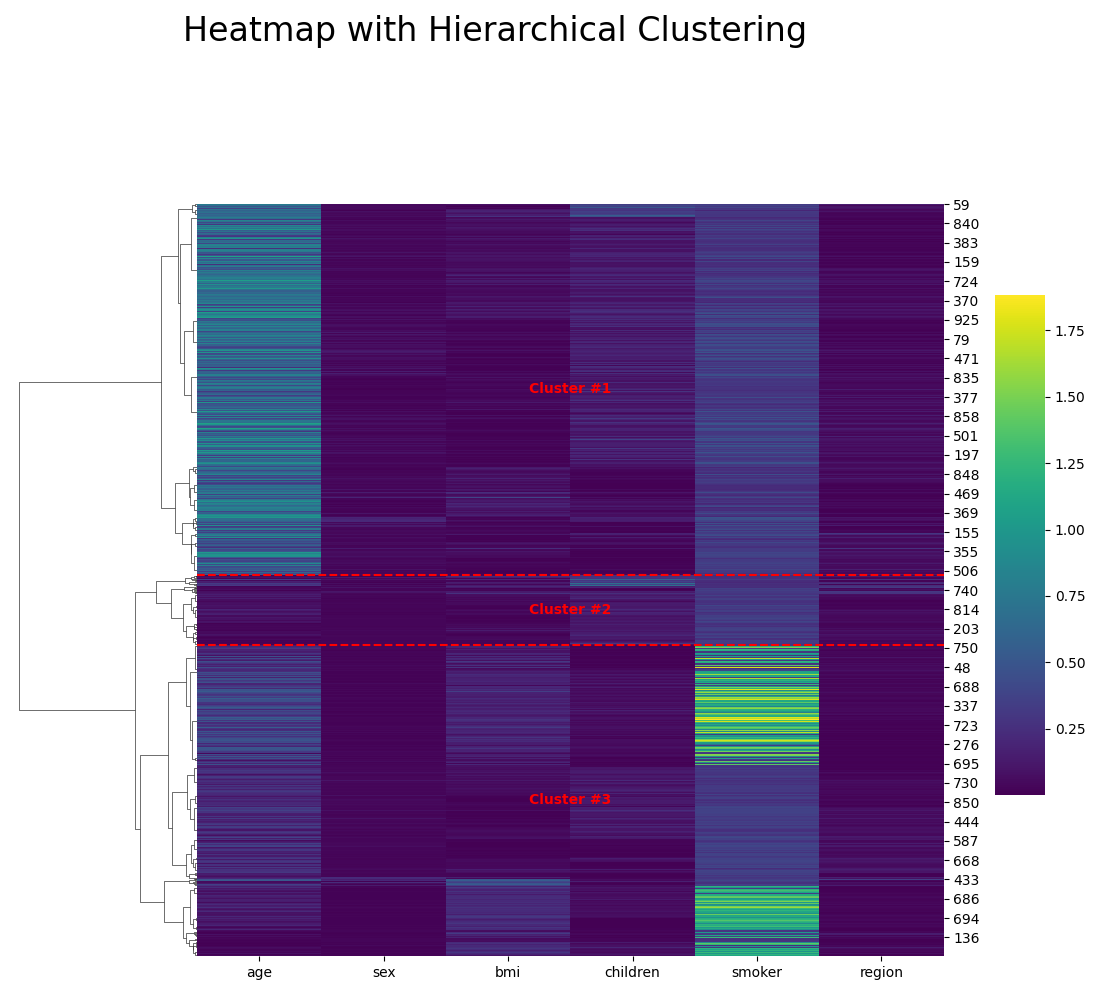

In [78]:
# get rbo distance matrix
rbo_train = compute_rbo_matrix(shap_rankings, form = 'distance')
shap_copy = pd.DataFrame(shap_values, columns=feature_names[:-1]).copy()
num_clusters = 3
clusters = assign_training_clusters(shap_copy, rbo_train, num_clusters)

We now check some summary statistics of the above clusters. It is worth noting that the subgroups that are 'discovered' by TreeSHAP either are composed entirely of smokers or of non-smokers.

In [79]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Data in Cluster #{i+1}:", X_train[clusters==i+1].shape[0]/X_train.shape[0])
print("---------------------------------------------")
# get average age in each cluster
for i in range(num_clusters):
    print(f"Average Age in Cluster #{i+1}:", X_train[clusters==i+1]['age'].mean())
print("---------------------------------------------")
# get percentage women in each cluster
for i in range(num_clusters):
    print(f"Proportion of Women in Cluster #{i+1}:", 1-X_train[clusters==i+1]['sex'].mean())
print("---------------------------------------------")
# get percentage men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Cluster #{i+1}:", X_train[clusters==i+1]['sex'].mean())
print("---------------------------------------------")
# get average bmi in each cluster
for i in range(num_clusters):
    print(f"Average BMI in Cluster #{i+1}:", X_train[clusters==i+1]['bmi'].mean())
print("---------------------------------------------")
# get average number of children in each cluster
for i in range(num_clusters):
    print(f"Average # of Children in Cluster #{i+1}:", X_train[clusters==i+1]['children'].mean())
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Proportion of Smokers in Cluster #{i+1}:", X_train[clusters==i+1]['smoker'].mean())
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Average Medical Expenses in Cluster #{i+1}:", y_train[clusters==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Data in Cluster #1: 0.4935897435897436
Proportion of Data in Cluster #2: 0.09294871794871795
Proportion of Data in Cluster #3: 0.41346153846153844
---------------------------------------------
Average Age in Cluster #1: 40.577922077922075
Average Age in Cluster #2: 36.59770114942529
Average Age in Cluster #3: 37.22739018087855
---------------------------------------------
Proportion of Women in Cluster #1: 0.5
Proportion of Women in Cluster #2: 0.5517241379310345
Proportion of Women in Cluster #3: 0.4599483204134367
---------------------------------------------
Proportion of Men in Cluster #1: 0.5
Proportion of Men in Cluster #2: 0.4482758620689655
Proportion of Men in Cluster #3: 0.5400516795865633
---------------------------------------------
Average BMI in Cluster #1: 30.515238095238097
Average BMI in Cluster #2: 30.319540229885064
Average BMI in Cluster #3: 30.96301033591731
---------------------------------------------
Av

## Evaluating Cluster Performance - Centroid Method w/ Exact Mean
Now that we have a good idea of what our clustering has done, we can check if this helps improve our predictions. We will take the test points and determine their cluster membership based on their RBO similarity to the mean point in each cluster (in RBO embedding). We will then fit a RF+ on the training data and using it to predict the test data for that cluster. We can then compute the R^2 and total squared error for each cluster's model. By summing the TSE across cluster models and comparing this to the original TSE reported above, we can get a good idea of how well these clusters improve model accuracy.

In [80]:
# get mdi rankings assignments for test points
shap_test_values = np.abs(explainer.shap_values(X_test, check_additivity=False))
shap_test_rankings = mdi_explainer.get_rankings(shap_test_values)

In [81]:
test_clust = assign_testing_clusters(method = "centroid", median_approx = False,
                                     rbo_distance_matrix = rbo_train,
                                     lfi_train_ranking = shap_rankings,
                                     lfi_test_ranking = shap_test_rankings,
                                     clusters = clusters)

In [82]:
cluster1_trainX = X_train[clusters == 1]
cluster2_trainX = X_train[clusters == 2]
cluster3_trainX = X_train[clusters == 3]
# cluster4_trainX = X_train[clusters == 4]
# cluster5_trainX = X_train[clusters == 5]
# cluster6_trainX = X_train[clusters == 6]
# cluster7_trainX = X_train[clusters == 7]

cluster1_trainy = y_train[clusters == 1]
cluster2_trainy = y_train[clusters == 2]
cluster3_trainy = y_train[clusters == 3]
# cluster4_trainy = y_train[clusters == 4]
# cluster5_trainy = y_train[clusters == 5]
# cluster6_trainy = y_train[clusters == 6]
# cluster7_trainy = y_train[clusters == 7]

cluster1_testX = X_test[test_clust == 1]
cluster2_testX = X_test[test_clust == 2]
cluster3_testX = X_test[test_clust == 3]
# cluster4_testX = X_test[test_clust == 4]
# cluster5_testX = X_test[test_clust == 5]
# cluster6_testX = X_test[test_clust == 6]
# cluster7_testX = X_test[test_clust == 7]

cluster1_testy = y_test[test_clust == 1]
cluster2_testy = y_test[test_clust == 2]
cluster3_testy = y_test[test_clust == 3]
# cluster4_testy = y_test[test_clust == 4]
# cluster5_testy = y_test[test_clust == 5]
# cluster6_testy = y_test[test_clust == 6]
# cluster7_testy = y_test[test_clust == 7]

In [83]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Train Data in Cluster #{i+1}: {X_train[clusters==i+1].shape[0]/X_train.shape[0]};",
          f"Proportion of Test Data in Cluster #{i+1}: {X_test[test_clust==i+1].shape[0]/X_test.shape[0]}")
print("---------------------------------------------")
# get average age in each cluster
for i in range(num_clusters):
    print(f"Average Age in Train Cluster #{i+1}:, {X_train[clusters==i+1]['age'].mean()};",
          f"Average Age in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['age'].mean()}")
print("---------------------------------------------")
# get percentage women in each cluster
for i in range(num_clusters):
    print(f"Proportion of Women in Train Cluster #{i+1}:, {1-X_train[clusters==i+1]['sex'].mean()};",
          f"Proportion of Women in Test Cluster #{i+1}:, {1-X_test[test_clust==i+1]['sex'].mean()}")    
print("---------------------------------------------")
# get percentage men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Train Cluster #{i+1}:, {X_train[clusters==i+1]['sex'].mean()};",
          f"Proportion of Men in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['sex'].mean()}")
print("---------------------------------------------")
# get average bmi in each cluster
for i in range(num_clusters):
    print(f"Average BMI in Train Cluster #{i+1}:, {X_train[clusters==i+1]['bmi'].mean()};",
          f"Average BMI in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['bmi'].mean()}")
print("---------------------------------------------")
# get average number of children in each cluster
for i in range(num_clusters):
    print(f"Average # of Children in Train Cluster #{i+1}:, {X_train[clusters==i+1]['children'].mean()};",
          f"Average # of Children in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['children'].mean()}")
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Proportion of Smokers in Train Cluster #{i+1}:, {X_train[clusters==i+1]['smoker'].mean()};",
          f"Proportion of Smokers in Test Cluster #{i+1}:, {X_test[test_clust==i+1]['smoker'].mean()}")
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Average Medical Expenses in Train Cluster #{i+1}:, {y_train[clusters==i+1].mean()};",
          f"Average Medical Expenses in Test Cluster #{i+1}:, {y_test[test_clust==i+1].mean()}")
print("---------------------------------------------")

---------------------------------------------
Proportion of Train Data in Cluster #1: 0.4935897435897436; Proportion of Test Data in Cluster #1: 0.5298507462686567
Proportion of Train Data in Cluster #2: 0.09294871794871795; Proportion of Test Data in Cluster #2: 0.07711442786069651
Proportion of Train Data in Cluster #3: 0.41346153846153844; Proportion of Test Data in Cluster #3: 0.39303482587064675
---------------------------------------------
Average Age in Train Cluster #1:, 40.577922077922075; Average Age in Test Cluster #1:, 42.15023474178404
Average Age in Train Cluster #2:, 36.59770114942529; Average Age in Test Cluster #2:, 37.45161290322581
Average Age in Train Cluster #3:, 37.22739018087855; Average Age in Test Cluster #3:, 37.860759493670884
---------------------------------------------
Proportion of Women in Train Cluster #1:, 0.5; Proportion of Women in Test Cluster #1:, 0.5258215962441315
Proportion of Women in Train Cluster #2:, 0.5517241379310345; Proportion of Women i

In [84]:
# fit RF+ on each training set, predict test
rf1 = RandomForestRegressor(n_estimators=100, random_state=0)
rf1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestRegressor(n_estimators=100, random_state=3)
rf2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestRegressor(n_estimators=100, random_state=0)
rf3.fit(cluster3_trainX, cluster3_trainy)

# rf4 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf4.fit(cluster4_trainX, cluster4_trainy)

# rf5 = RandomForestRegressor(n_estimators=100, random_state=1)
# rf5.fit(cluster5_trainX, cluster5_trainy)

# rf6 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf6.fit(cluster6_trainX, cluster6_trainy)

# rf7 = RandomForestRegressor(n_estimators=100, random_state=1)
# rf7.fit(cluster7_trainX, cluster7_trainy)

RandomForestRegressor(random_state=0)

In [85]:
# compute r^2 on the test set
print("---------------------------------------------")
y_pred1 = rf1.predict(cluster1_testX)
r2 = r2_score(cluster1_testy, y_pred1)
tse1 = np.sum((cluster1_testy - y_pred1)**2)
print(f'RF+ Cluster #1 Test Set R^2: {r2}')
print(f'RF+ Cluster #1 Test Set TSE: {tse1}')
y_pred_g1 = rf.predict(cluster1_testX)
r2g = r2_score(cluster1_testy, y_pred_g1)
tse1g = np.sum((cluster1_testy - y_pred_g1)**2)
print(f'Global RF+ Cluster #1 Test Set R^2: {r2g}')
print(f'Global RF+ Cluster #1 Test Set TSE: {tse1g}')
print("---------------------------------------------")
y_pred2 = rf2.predict(cluster2_testX)
r2 = r2_score(cluster2_testy, y_pred2)
tse2 = np.sum((cluster2_testy - y_pred2)**2)
print(f'RF+ Cluster #2 Test Set R^2: {r2}')
print(f'RF+ Cluster #2 Test Set TSE: {tse2}')
y_pred_g2 = rf.predict(cluster2_testX)
r2g = r2_score(cluster2_testy, y_pred_g2)
tse2g = np.sum((cluster2_testy - y_pred_g2)**2)
print(f'Global RF+ Cluster #2 Test Set R^2: {r2g}')
print(f'Global RF+ Cluster #2 Test Set TSE: {tse2g}')
print("---------------------------------------------")
y_pred3 = rf3.predict(cluster3_testX)
r2 = r2_score(cluster3_testy, y_pred3)
tse3 = np.sum((cluster3_testy - y_pred3)**2)
print(f'RF+ Cluster #3 Test Set R^2: {r2}')
print(f'RF+ Cluster #3 Test Set TSE: {tse3}')
y_pred_g3 = rf.predict(cluster3_testX)
r2g = r2_score(cluster3_testy, y_pred_g3)
tse3g = np.sum((cluster3_testy - y_pred_g3)**2)
print(f'Global RF+ Cluster #3 Test Set R^2: {r2g}')
print(f'Global RF+ Cluster #3 Test Set TSE: {tse3g}')
print("---------------------------------------------")
# y_pred4 = rf4.predict(cluster4_testX)
# r2 = r2_score(cluster4_testy, y_pred4)
# tse4 = np.sum((cluster4_testy - y_pred4)**2)
# print(f'RF+ Cluster #4 Test Set R^2: {r2}')
# print(f'RF+ Cluster #4 Test Set TSE: {tse4}')
# print("---------------------------------------------")
# y_pred5 = rf5.predict(cluster5_testX)
# r2 = r2_score(cluster5_testy, y_pred5)
# tse5 = np.sum((cluster5_testy - y_pred5)**2)
# print(f'RF+ Cluster #5 Test Set R^2: {r2}')
# print(f'RF+ Cluster #5 Test Set TSE: {tse5}')
# print("---------------------------------------------")
# y_pred6 = rf6.predict(cluster6_testX)
# r2 = r2_score(cluster6_testy, y_pred6)
# tse6 = np.sum((cluster6_testy - y_pred6)**2)
# print(f'RF+ Cluster #6 Test Set R^2: {r2}')
# print(f'RF+ Cluster #6 Test Set TSE: {tse6}')
# print("---------------------------------------------")
# y_pred7 = rf7.predict(cluster7_testX)
# r2 = r2_score(cluster7_testy, y_pred7)
# tse7 = np.sum((cluster7_testy - y_pred7)**2)
# print(f'RF+ Cluster #7 Test Set R^2: {r2}')
# print(f'RF+ Cluster #7 Test Set TSE: {tse7}')
# print("---------------------------------------------")

---------------------------------------------
RF+ Cluster #1 Test Set R^2: 0.7954807176710599
RF+ Cluster #1 Test Set TSE: 33.97710269064372
Global RF+ Cluster #1 Test Set R^2: 0.7971226721797012
Global RF+ Cluster #1 Test Set TSE: 33.70432226467027
---------------------------------------------
RF+ Cluster #2 Test Set R^2: -0.6955215097355831
RF+ Cluster #2 Test Set TSE: 9.273467030510359
Global RF+ Cluster #2 Test Set R^2: -0.2848002996970307
Global RF+ Cluster #2 Test Set TSE: 7.027072880890977
---------------------------------------------
RF+ Cluster #3 Test Set R^2: 0.8716513090625141
RF+ Cluster #3 Test Set TSE: 15.623300295525235
Global RF+ Cluster #3 Test Set R^2: 0.9063857777044271
Global RF+ Cluster #3 Test Set TSE: 11.39523197449791
---------------------------------------------


In [86]:
print("---------------------------------------------")
print("Total # of Observations Predicted by Global Model:", X_test.shape[0])
print("Total # of Observations Predicted by Cluster Models:",
      cluster1_testX.shape[0] + cluster2_testX.shape[0] + \
          cluster3_testX.shape[0])
print("---------------------------------------------")
print("Difference in TSE (Global - Sum of Clusters):", round(tse - (tse1 + tse2 + tse3), 2))
print(f"Percent Improvement Over Global Model: {round(100*(tse - (tse1 + tse2 + tse3))/tse, 2)}%")
print("---------------------------------------------")

---------------------------------------------
Total # of Observations Predicted by Global Model: 402
Total # of Observations Predicted by Cluster Models: 402
---------------------------------------------
Difference in TSE (Global - Sum of Clusters): -6.75
Percent Improvement Over Global Model: -12.94%
---------------------------------------------


In [87]:
# order rows of mdi_test by cluster assignment
shap_test_clust = shap_test_values[np.argsort(test_clust)]

In [88]:
# order test clust by cluster assignment
shap_test_clust_org = test_clust[np.argsort(test_clust)]

In [89]:
# get indexes where mdi_test_clust changes clusters
cluster_changes = np.where(np.diff(shap_test_clust_org) != 0)[0]

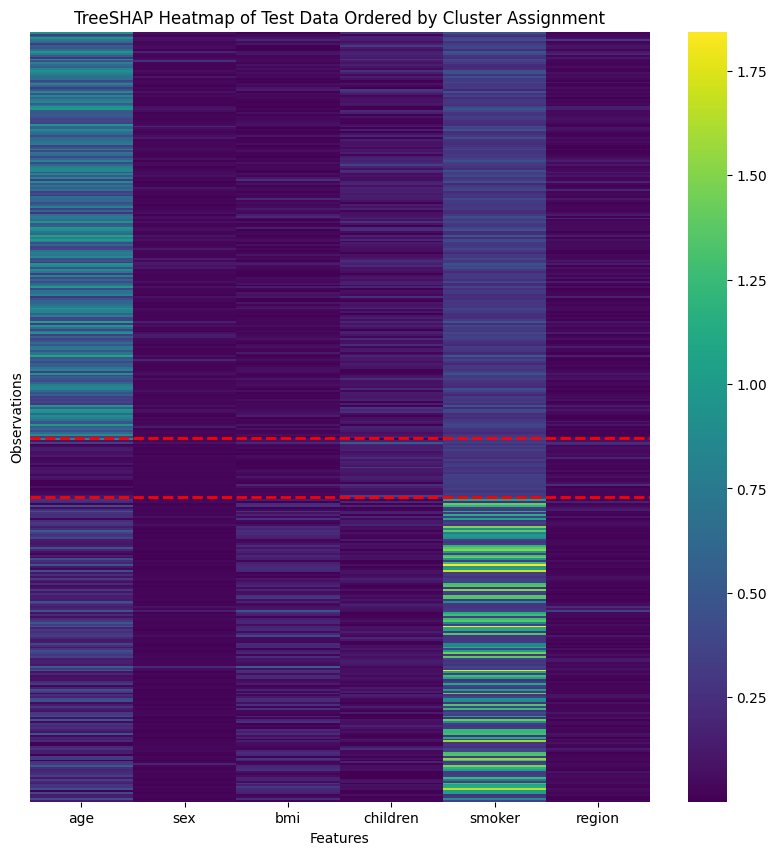

In [90]:
# create new heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(shap_test_clust, cmap='viridis')
plt.xlabel('Features')
plt.ylabel('Observations')
plt.title('TreeSHAP Heatmap of Test Data Ordered by Cluster Assignment')
plt.yticks([])
plt.xticks(np.arange(len(feature_names[:-1])) + 0.5, feature_names[:-1])
# put horizontal lines where cluster membership changes
for i in cluster_changes:
    plt.axhline(i, color='red', linewidth=2, linestyle='--')
plt.show()

In [91]:
# get most important feature on average for each cluster
for i in range(num_clusters):
    print(f'The most important feature for Train Cluster #{i+1} is:', X.columns[np.argmax(np.mean(shap_values[clusters==i+1], axis=0))])
    print(f'The most important feature for Test Cluster #{i+1} is:', X.columns[np.argmax(np.mean(shap_test_values[test_clust==i+1], axis=0))])

The most important feature for Train Cluster #1 is: age
The most important feature for Test Cluster #1 is: age
The most important feature for Train Cluster #2 is: smoker
The most important feature for Test Cluster #2 is: smoker
The most important feature for Train Cluster #3 is: smoker
The most important feature for Test Cluster #3 is: smoker


In [92]:
for i in range(num_clusters):
    # negative is taken because argsort goes in the wrong order
    print(f'The feature ranking for Train Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(shap_values[clusters==i+1], axis=0))]))
    print(f'The feature ranking for Test Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(shap_test_values[test_clust==i+1], axis=0))]))

The feature ranking for Train Cluster #1 is: ['age', 'smoker', 'children', 'bmi', 'region', 'sex']
The feature ranking for Test Cluster #1 is: ['age', 'smoker', 'children', 'region', 'bmi', 'sex']
The feature ranking for Train Cluster #2 is: ['smoker', 'children', 'age', 'region', 'bmi', 'sex']
The feature ranking for Test Cluster #2 is: ['smoker', 'children', 'age', 'region', 'bmi', 'sex']
The feature ranking for Train Cluster #3 is: ['smoker', 'age', 'bmi', 'children', 'region', 'sex']
The feature ranking for Test Cluster #3 is: ['smoker', 'age', 'bmi', 'children', 'region', 'sex']
